🎒 Step 1: Replay Buffer Code Block

In [2]:
# 🎒 Replay Buffer - Experience Replay Memory

import random
from collections import deque
import numpy as np

class ReplayBuffer:
    """
    A fixed-size buffer that stores agent experiences for training the Q-network.

    Attributes:
        buffer (deque): A double-ended queue to store experience tuples.
        capacity (int): Maximum number of experiences the buffer can hold.
    """

    def __init__(self, capacity=100_000):
        """
        Initialize the replay buffer.

        Args:
            capacity (int): Maximum number of transitions to store in the buffer.
        """
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """
        Store a new experience in the buffer.

        Args:
            state (np.ndarray): The current state.
            action (int): The action taken.
            reward (float): The reward received.
            next_state (np.ndarray): The resulting next state.
            done (bool): Whether the episode has ended.
        """
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """
        Sample a batch of experiences from the buffer.

        Args:
            batch_size (int): The number of samples to return.

        Returns:
            tuple of np.ndarrays: Batched (states, actions, rewards, next_states, dones)
        """
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.uint8)
        )

    def __len__(self):
        """
        Return the current size of the buffer.

        Returns:
            int: Number of stored experiences.
        """
        return len(self.buffer)


In [3]:
# 🧪 Testing the ReplayBuffer functionality

# Create a buffer with small capacity for testing
buffer = ReplayBuffer(capacity=10)

# Push in 5 dummy experiences
for i in range(5):
    state = np.zeros(8) + i  # Fake state vector (8 features like LunarLander)
    action = i % 4
    reward = float(i)
    next_state = state + 1
    done = i % 2 == 0
    buffer.push(state, action, reward, next_state, done)

print(f"✅ Buffer size after pushing: {len(buffer)}")

# Sample 3 experiences
sampled = buffer.sample(3)
print("✅ Sampled batch shapes:")
print("States shape:", sampled[0].shape)
print("Actions shape:", sampled[1].shape)
print("Rewards shape:", sampled[2].shape)
print("Next States shape:", sampled[3].shape)
print("Dones shape:", sampled[4].shape)


✅ Buffer size after pushing: 5
✅ Sampled batch shapes:
States shape: (3, 8)
Actions shape: (3,)
Rewards shape: (3,)
Next States shape: (3, 8)
Dones shape: (3,)


🧠 Step 2: Q-Network (Neural Net Brain)

In [4]:
# 🧠 Q-Network - The Deep Neural Network Approximator

import torch
import torch.nn as nn

class QNetwork(nn.Module):
    """
    A feedforward neural network that estimates Q-values for each action
    given a state input from the environment.

    Attributes:
        model (nn.Sequential): The sequential network architecture.
    """

    def __init__(self, state_size, action_size):
        """
        Initialize the Q-network layers.

        Args:
            state_size (int): Dimension of the input state.
            action_size (int): Number of possible discrete actions.
        """
        super(QNetwork, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )

    def forward(self, x):
        """
        Forward pass of the network.

        Args:
            x (torch.Tensor): The input state tensor.

        Returns:
            torch.Tensor: The predicted Q-values for each action.
        """
        return self.model(x)


In [5]:
# 🧪 Testing the QNetwork with dummy input

state_size = 8     # LunarLander-v2 has 8 state features
action_size = 4    # 4 discrete actions

net = QNetwork(state_size, action_size)

dummy_input = torch.randn(1, state_size)
output = net(dummy_input)

print("✅ Output Q-values:", output)
print("✅ Output shape:", output.shape)


✅ Output Q-values: tensor([[ 0.0183, -0.1616,  0.0058,  0.0830]], grad_fn=<AddmmBackward0>)
✅ Output shape: torch.Size([1, 4])


🤖 Step 3: DQN Agent Class

In [6]:
# 🤖 DQN Agent - The Reinforcement Learning Engine

import torch.optim as optim

class DQNAgent:
    """
    Deep Q-Learning Agent that interacts with and learns from the environment.

    Attributes:
        q_network (QNetwork): Main Q-network used to predict Q-values.
        target_network (QNetwork): Target Q-network for stable learning.
        optimizer (torch.optim.Adam): Optimizer for updating q_network weights.
        buffer (ReplayBuffer): Memory buffer for storing experiences.
        gamma (float): Discount factor for future rewards.
        epsilon (float): Exploration rate for epsilon-greedy policy.
    """

    def __init__(self, state_size, action_size, buffer, lr=1e-3, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        """
        Initialize the agent.

        Args:
            state_size (int): Number of features in the environment state.
            action_size (int): Number of discrete actions.
            buffer (ReplayBuffer): Replay buffer instance.
            lr (float): Learning rate for the optimizer.
            gamma (float): Discount factor.
            epsilon (float): Initial exploration rate.
            epsilon_decay (float): Rate at which epsilon decays.
            epsilon_min (float): Minimum value of epsilon.
        """
        self.q_network = QNetwork(state_size, action_size)
        self.target_network = QNetwork(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.buffer = buffer

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.action_size = action_size

    def act(self, state):
        """
        Select an action using epsilon-greedy strategy.

        Args:
            state (np.ndarray): Current state.

        Returns:
            int: Action index.
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_network(state)
        return q_values.argmax().item()

    def learn(self, batch_size):
        """
        Sample a batch from memory and perform a learning step.

        Args:
            batch_size (int): Size of the mini-batch for learning.
        """
        if len(self.buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample(batch_size)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        q_values = self.q_network(states).gather(1, actions)
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1, keepdim=True)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q_values

        loss = nn.MSELoss()(q_values, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def update_epsilon(self):
        """
        Decay the exploration rate after each episode.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def update_target_network(self):
        """
        Copy weights from the main Q-network to the target network.
        """
        self.target_network.load_state_dict(self.q_network.state_dict())


🔁 Step 4: Training Loop

In [7]:
# 🔁 Training Loop - Interact, Learn, and Track Progress
import os
import gymnasium as gym
from tqdm import trange

# Environment setup
env = gym.make("LunarLander-v3")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Agent setup
buffer = ReplayBuffer(capacity=100_000)
agent = DQNAgent(state_size, action_size, buffer)

# Training hyperparameters
num_episodes = 1000
batch_size = 64
target_update_freq = 10  # how often to sync target network

# Tracking
reward_history = []
loss_history = []

# Training loop
for episode in trange(num_episodes, desc="🚀 Training"):
    state, _ = env.reset()
    total_reward = 0
    losses = []

    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent.buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        # Learning step
        loss = agent.learn(batch_size)
        if loss is not None:
            losses.append(loss)

    # End-of-episode updates
    agent.update_epsilon()
    if episode % target_update_freq == 0:
        agent.update_target_network()

    # Track performance
    reward_history.append(total_reward)
    avg_loss = np.mean(losses) if losses else 0
    loss_history.append(avg_loss)

    # Print episode summary every 100
    if (episode + 1) % 100 == 0:
        print(f"🎯 Episode {episode+1} - Reward: {total_reward:.2f} | Epsilon: {agent.epsilon:.3f} | Loss: {avg_loss:.4f}")

🚀 Training:  10%|█         | 100/1000 [00:42<07:34,  1.98it/s]

🎯 Episode 100 - Reward: -75.79 | Epsilon: 0.606 | Loss: 20.9553


🚀 Training:  20%|██        | 200/1000 [03:01<20:35,  1.54s/it]

🎯 Episode 200 - Reward: -156.54 | Epsilon: 0.367 | Loss: 7.0477


🚀 Training:  30%|███       | 300/1000 [09:54<50:52,  4.36s/it]  

🎯 Episode 300 - Reward: -32.35 | Epsilon: 0.222 | Loss: 3.9546


🚀 Training:  40%|████      | 400/1000 [41:09<21:09,  2.12s/it]    

🎯 Episode 400 - Reward: 14.00 | Epsilon: 0.135 | Loss: 2.3749


🚀 Training:  50%|█████     | 500/1000 [47:04<29:25,  3.53s/it]

🎯 Episode 500 - Reward: -49.39 | Epsilon: 0.082 | Loss: 3.7069


🚀 Training:  60%|██████    | 600/1000 [53:20<21:07,  3.17s/it]

🎯 Episode 600 - Reward: 236.31 | Epsilon: 0.049 | Loss: 3.6503


🚀 Training:  70%|███████   | 700/1000 [57:20<10:18,  2.06s/it]

🎯 Episode 700 - Reward: 227.01 | Epsilon: 0.030 | Loss: 5.7991


🚀 Training:  80%|████████  | 800/1000 [59:28<04:43,  1.42s/it]

🎯 Episode 800 - Reward: 214.45 | Epsilon: 0.018 | Loss: 15.1150


🚀 Training:  90%|█████████ | 900/1000 [1:01:19<03:32,  2.13s/it]

🎯 Episode 900 - Reward: -304.95 | Epsilon: 0.011 | Loss: 15.9521


🚀 Training: 100%|██████████| 1000/1000 [1:03:08<00:00,  3.79s/it]

🎯 Episode 1000 - Reward: 297.72 | Epsilon: 0.010 | Loss: 23.3707


💾 Save the Trained Model (Run This Once Training is Done)


In [8]:
# 💾 Save Q-network if already trained

model_path = "results/models/dqn_agent.pth"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(agent.q_network.state_dict(), model_path)
print(f"✅ Model saved to {model_path}")

✅ Model saved to results/models/dqn_agent.pth


📈 Step 5: Plot Rewards and Training Loss

c:\Users\Roy_t\OneDrive\Desktop\GitHub\lunar-landar-dqn\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


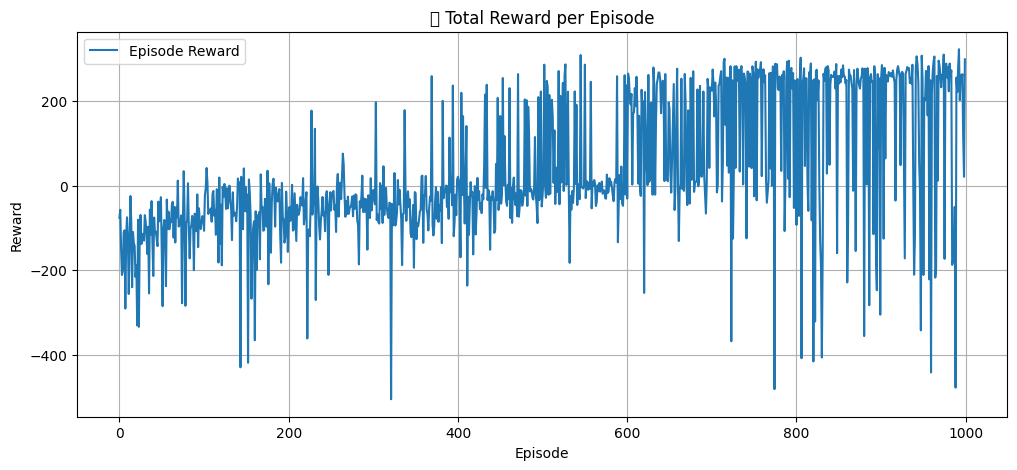

c:\Users\Roy_t\OneDrive\Desktop\GitHub\lunar-landar-dqn\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


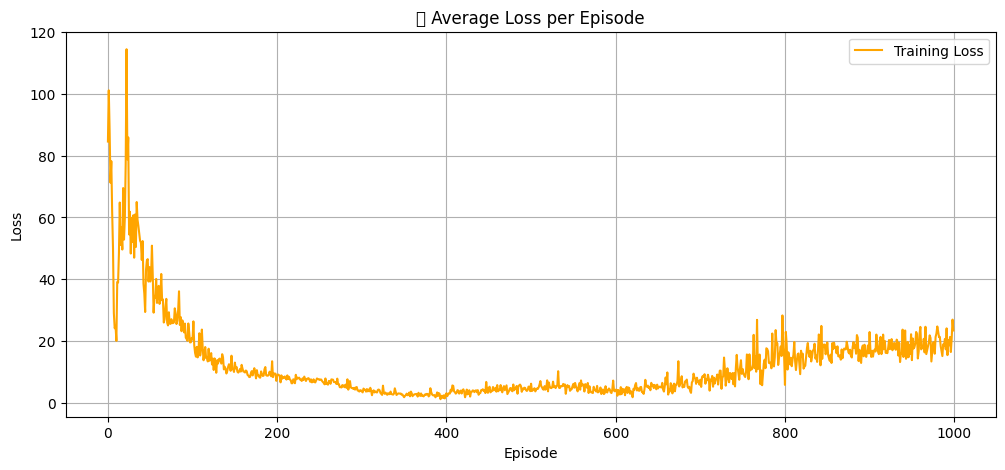

In [9]:
# 📈 Plotting Reward and Training Loss Over Time

import matplotlib.pyplot as plt

# Plot total reward per episode
plt.figure(figsize=(12, 5))
plt.plot(reward_history, label="Episode Reward")
plt.title("🚀 Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.show()

# Plot training loss
plt.figure(figsize=(12, 5))
plt.plot(loss_history, label="Training Loss", color="orange")
plt.title("📉 Average Loss per Episode")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


🎥 Step 6: Record a Video of the Trained Agent

In [10]:
# 🎥 Record the Trained Agent Landing

from gymnasium.wrappers import RecordVideo
import os

# Define video output folder
video_dir = "results/videos"
os.makedirs(video_dir, exist_ok=True)

# Create a wrapped environment for recording
env = gym.make("LunarLander-v3", render_mode="rgb_array")
env = RecordVideo(
    env,
    video_folder=video_dir,
    episode_trigger=lambda episode_id: True,
    name_prefix="lunar_lander"
)

# Reload best-performing agent (optional if already in memory)
agent.epsilon = 0.0  # Turn off exploration for evaluation

for episode in range(3):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.act(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    print(f"🎬 Episode {episode + 1} finished with reward: {total_reward:.2f}")

env.close()


c:\Users\Roy_t\OneDrive\Desktop\GitHub\lunar-landar-dqn\venv\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Roy_t\OneDrive\Desktop\GitHub\lunar-landar-dqn\results\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


🎬 Episode 1 finished with reward: 201.99
🎬 Episode 2 finished with reward: 278.01
🎬 Episode 3 finished with reward: 242.87


🎞️ Convert .mp4 to .gif

In [11]:
# 🌀 Convert Recorded MP4 to GIF

import imageio
import os

# Locate your video
video_path = "results/videos/lunar_lander-episode-0.mp4"
gif_path = "results/videos/lunar_lander.gif"

# Read frames and save as GIF
reader = imageio.get_reader(video_path, format="ffmpeg")
fps = reader.get_meta_data()["fps"]

writer = imageio.get_writer(gif_path, format="GIF", fps=fps)

for frame in reader:
    writer.append_data(frame)
writer.close()

print(f"✅ GIF saved at: {gif_path}")


✅ GIF saved at: results/videos/lunar_lander.gif


🎯 1. Evaluate and Capture the Best Episode

In [12]:
# 🎯 Record Only the Best Landing Episode for GIF

import gymnasium as gym
import os
import imageio

env = gym.make("LunarLander-v3", render_mode="rgb_array")

best_reward = -float("inf")
best_frames = []

agent.epsilon = 0.0  # No exploration during evaluation

for episode in range(5):  # Run 5 evaluation episodes
    state, _ = env.reset()
    done = False
    frames = []
    total_reward = 0

    while not done:
        frame = env.render()  # Capture current frame
        frames.append(frame)

        action = agent.act(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    print(f"🎬 Episode {episode+1} reward: {total_reward:.2f}")

    if total_reward > best_reward:
        best_reward = total_reward
        best_frames = frames.copy()

env.close()
print(f"🏆 Best reward: {best_reward:.2f}")


🎬 Episode 1 reward: 252.92
🎬 Episode 2 reward: -261.72
🎬 Episode 3 reward: 273.30
🎬 Episode 4 reward: -79.21
🎬 Episode 5 reward: -223.55
🏆 Best reward: 273.30


🌀 2. Save the Best Frames as a GIF

In [13]:
# 💾 Save Best Landing as a GIF

os.makedirs("results/videos", exist_ok=True)
gif_path = "results/videos/best_landing.gif"

imageio.mimsave(gif_path, best_frames, fps=30)
print(f"✅ GIF saved to {gif_path}")


✅ GIF saved to results/videos/best_landing.gif
